In [ ]:
#!pip install tensorflow==2.8.2

In [ ]:
#!pip install keras

In [1]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical ,Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, Dropout
from tensorflow.keras.optimizers import Adadelta, Nadam ,Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, TensorBoard
import tensorflow as tf

from sklearn.model_selection import train_test_split
from datetime import datetime
from google.cloud import storage
from google.cloud import bigquery
from google.oauth2 import service_account
from sklearn.impute import KNNImputer
from sklearn import preprocessing
import keras.models
from keras.models import Sequential
from keras.layers import Activation, Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import StandardScaler

import load_data

z_scaler = preprocessing.StandardScaler()
client = bigquery.Client()

2022-09-16 22:33:00.761084: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-16 22:33:00.761144: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
tf.__version__

'2.8.2'

In [3]:
client = bigquery.Client()

In [4]:
PROJECT_ID = 'zmx-sugar-sales-ml-d'

In [ ]:
# load_data.load_data_sniim()
# load_data.load_data_bh()

### CARGAR DATOS

In [5]:
def load_data_sniim():
    client = bigquery.Client()
    data_sniim_estado = client.query(f""" SELECT date_time AS Fecha, Estado, AVG(valor) AS Valor_Promedio_SNIIM FROM (
      SELECT A.*, B.Estado
      FROM ( SELECT * FROM `zmx-sugar-sales-ml-d.raw.SNIM_PRECIOS_REFERENCIA` ) A
      LEFT JOIN ( SELECT * FROM `zmx-sugar-sales-ml-d.raw.prueba_grupos` ) B
      ON A.Centro_distribucion = B.Ingenio)
    GROUP BY date_time, Estado;""").to_dataframe() 
    return data_sniim_estado

def load_data_bh():
    client = bigquery.Client()
    data_precio_bh_estado = client.query(f""" SELECT DATE(fecha) as Fecha, ingenio as Ingenio, Estado, AVG(precio_base) AS Precio_Base_Promedio FROM (
    SELECT A.*, B.Estado
    FROM ( SELECT * FROM `zmx-sugar-sales-ml-d.raw.SQLSERVER_VENTAS_HIST` ) A
    LEFT JOIN ( SELECT * FROM `zmx-sugar-sales-ml-d.raw.prueba_grupos` ) B
    ON A.ingenio = B.Ingenio)
    GROUP BY Fecha, Ingenio, Estado; """).to_dataframe()
    return data_precio_bh_estado

In [6]:
data_sniim_estado = client.query(f""" SELECT date_time AS Fecha, UPPER(Estado) as Estado, AVG(valor) AS Valor_Promedio_SNIIM FROM (
   SELECT A.*, B.Estado
   FROM ( SELECT * FROM `zmx-sugar-sales-ml-d.raw.SNIM_PRECIOS_REFERENCIA` ) A
   LEFT JOIN ( SELECT * FROM `zmx-sugar-sales-ml-d.raw.prueba_grupos` ) B
   ON A.Centro_distribucion = B.Ingenio)
GROUP BY date_time, Estado;""").to_dataframe() 
 #return data_sniim_estado
    
client = bigquery.Client()
data_precio_bh_estado = client.query(f""" SELECT DATE(fecha) as Fecha, ingenio as Ingenio, UPPER(Estado) as Estado, AVG(precio_base) AS Precio_Base_Promedio FROM (
SELECT A.*, B.Estado
FROM ( SELECT * FROM `zmx-sugar-sales-ml-d.raw.precio-base-historico` ) A
LEFT JOIN ( SELECT * FROM `zmx-sugar-sales-ml-d.raw.prueba_grupos` ) B
ON A.ingenio = B.Ingenio)
GROUP BY Fecha, Ingenio, Estado; """).to_dataframe()

In [7]:
data_sniim_estado.shape

(79921, 3)

In [8]:
#bh = client.query(f""" SELECT * FROM `zmx-sugar-sales-ml-d.raw.precio-base-historico` """).to_dataframe()

In [ ]:
#data_precio_bh_estado.shape , bh.shape

## FUENTES

In [ ]:
prueba = client.query(f""" SELECT * FROM `zmx-sugar-sales-ml-d.raw.prueba_grupos` """).to_dataframe()
inventarios = client.query(f""" SELECT partida, PRODUCTOCODIGO, DATE(FECHA) as Fecha, ALMACEN, Cantidad, Costo, Tipo_Movimiento 
                        FROM `zmx-sugar-sales-ml-d.raw.SQLSERVER_INVENTARIOS` """).to_dataframe()
tarifas = client.query(f""" SELECT Almacen, PaisDestino, EstadoDestino, EstadoOrigen as Estado, PrecioTonelada, DATE(fecha_vigencia) as Fecha 
                        FROM `zmx-sugar-sales-ml-d.raw.SQLSERVER_TARIFAS_TONELADA` """).to_dataframe()
ventas = client.query(f""" SELECT * FROM `zmx-sugar-sales-ml-d.raw.prueba_ventas` """).to_dataframe()
almacenes = client.query(f""" SELECT * FROM `zmx-sugar-sales-ml-d.raw.prueba_almacenes` """).to_dataframe()

# FALTA COMPARATIVOS

# VENTAS Y ALMACENES
ventas = ventas.rename(columns={'ALMACEN':'Almacen',})
ventas1 = pd.merge(ventas,almacenes,how='left',on=["Almacen"])


In [ ]:
data_precio_bh_estado.shape, inventarios.shape, 
print("data_precio_bh_estado ==",data_precio_bh_estado.columns) 
print("inventarios ==",inventarios.columns) 
print("ventas ==",ventas.columns)
print("tarifas ==",tarifas.columns) 
print("prueba ==",prueba.columns)
print("almacenes ==",almacenes.columns)

In [ ]:
data_sniim_estado["Estado"]=data_sniim_estado["Estado"].replace("ESTADO DE MÉXICO", "ESTADO DE MEXICO")
data_sniim_estado["Estado"]=data_sniim_estado["Estado"].replace("MICHOACÁN", "MICHOACAN")
data_sniim_estado["Estado"]=data_sniim_estado["Estado"].replace("QUERÉTARO", "QUERETARO")
data_sniim_estado["Estado"]=data_sniim_estado["Estado"].replace("NUEVO LEÓN", "NUEVO LEON")
data_sniim_estado["Estado"]=data_sniim_estado["Estado"].replace("CIUDAD DE MÉXICO", "CIUDAD DE MEXICO")

In [ ]:
tarifas["Fecha"].max(),tarifas["Fecha"].min() 

# NO CORRER

#### ANALIZANDO ALMACENES

In [ ]:
almacenes.columns

In [ ]:
almacenes.shape

#### ANALIZANDO VENTAS

In [ ]:
ventas.columns

In [ ]:
ventas.shape

#### UNIENDO VENTAS CON ALMACENES

In [ ]:
ventas1 = pd.merge(ventas,almacenes,how='left',on=["Almacen"])

In [ ]:
len(set(ventas2["Almacen"]) & set(inventarios["Almacen"]))

In [ ]:
almacenes["Almacen"].unique()

In [ ]:
len(set(ventas["Almacen"].unique()) & set(almacenes["Almacen"].unique())), len(set(ventas["Almacen"].unique())),len(set(almacenes["Almacen"].unique()))

In [ ]:
#REVISAR COINCIDENCIAS ALMACEN, REVISAR FECHAS VIEJAS /// HACER LISTAS DE COINCIDENCIA Y NO COINCIDENCIA

In [ ]:
len(set(almacenes["Almacen"].unique()) - set(ventas["Almacen"].unique()))

In [ ]:
ventas1.shape

In [ ]:
ventas1.isnull().sum()

In [ ]:
ventas1=ventas1.dropna()
ventas1 = ventas1.drop_duplicates() 

In [ ]:
ventas1.shape

In [ ]:
ventas1.columns

In [ ]:
# FILTRAR EL PRODUCTO CODIGO DE AZUCAR POR TONELADA /// TODO LO QUE DIGA AZÚCAR ESTÁNDAR

In [ ]:
ventas1.head()

In [ ]:
ventas2=ventas1.groupby(['PRODUCTOCODIGO','FECHA','Almacen','Tipo_Movimiento','Estado'])['Cantidad'].mean().reset_index()

In [ ]:
ventas2.shape #280292 #168026

In [ ]:
ventas2 = ventas2.rename(columns={'FECHA':'Fecha',})

In [ ]:
ventas2.head()

In [ ]:
ventas2["Fecha"]=ventas2["Fecha"].astype(str)

In [ ]:
ventas2["Fecha"].max() , ventas2["Fecha"].min()

#### INVENTARIOS

In [ ]:
inventarios["Fecha"]=inventarios["Fecha"].astype(str)

In [ ]:
inventarios = inventarios.rename(columns={'ALMACEN':'Almacen',})

In [ ]:
inventarios.columns

In [ ]:
len(set(inventarios["Almacen"]))

In [ ]:
len(set(ventas2["Almacen"]) & set(inventarios["Almacen"])), len(set(ventas2["Almacen"])), len(set(inventarios["Almacen"]))

In [ ]:
ventas1["FECHA"] = ventas1["FECHA"].astype(str) 
data_precio_bh_estado["Fecha"] = data_precio_bh_estado["Fecha"].astype(str)

In [ ]:
len(set(ventas1["FECHA"]) & set(data_precio_bh_estado["Fecha"]))

In [ ]:
len(set(ventas2["Fecha"]) & set(data_precio_bh_estado["Fecha"]))

In [ ]:
inventarios.columns

In [ ]:
len(set(inventarios["Fecha"]) & set(data_precio_bh_estado["Fecha"]))

In [ ]:
len(data_precio_bh_estado["Fecha"].unique())

In [ ]:
len(set(inventarios["Fecha"]) & set(ventas2["Fecha"])), len(set(inventarios["Fecha"])), len(set(ventas2["Fecha"]))

In [ ]:
ventas2["Fecha"].min(), data_precio_bh_estado["Fecha"].min(), ventas2["Fecha"].max(), data_precio_bh_estado["Fecha"].max()

In [ ]:
inventarios["Fecha"].max(), inventarios["Fecha"].min()

In [ ]:
len(set(data_precio_bh_estado["Fecha"]))

In [ ]:
data_precio_bh_estado.columns

In [ ]:
inventarios.shape , ventas2.shape

In [ ]:
ventas3 = pd.merge(ventas2,inventarios,how='left',on=["Fecha","Almacen"])

In [ ]:
#ventas3.head()

In [ ]:
ventas3.shape

In [ ]:
ventas3.isnull().sum()

In [ ]:
ventas3=ventas3.dropna()
ventas3 = ventas3.drop_duplicates() 

In [ ]:
ventas3.head()

In [ ]:
len(set(ventas3["Fecha"]) & set(data_precio_bh_estado["Fecha"]))

#### TARIFAS

In [ ]:
len(set(inventarios["Fecha"]) & set(data_precio_bh_estado["Fecha"]))

In [ ]:
## ESTADO DE ALMACENES NO SE HA VERIFICADO /// hacer una buena revision de almacen de inventarios y de almacenes // revisar fechas de almacenes

In [ ]:
inventarios.columns , data_precio_bh_estado.columns, almacenes.columns

In [ ]:
inventarios1 = pd.merge(inventarios, almacenes,how='left',on=["Almacen"] )

In [ ]:
len(set(inventarios["Almacen"]) & set(almacenes["Almacen"])) , len(inventarios["Almacen"].unique()), len(almacenes["Almacen"].unique())

In [ ]:
for i in almacenes["Almacen"].unique():
    print(i)

In [ ]:
inventarios1.shape, inventarios.shape

In [ ]:
inventarios1.isnull().sum()

In [ ]:
tarifas.shape 

In [ ]:
tarifas["Fecha"].max() , tarifas["Fecha"].min()

In [ ]:
tarifas["Fecha"]=tarifas["Fecha"].astype(str)

In [ ]:
len(set(tarifas["Fecha"]) & set(data_precio_bh_estado["Fecha"]))

In [ ]:
data_precio_bh_estado["Fecha"].unique()

In [ ]:
tarifas["Fecha"].unique()

In [ ]:
inventarios2 = pd.merge(inventarios,almacenes,how='left',on=["Almacen"])

In [ ]:
inventarios2.shape

In [ ]:
data_precio_bh_estado.shape

In [ ]:
prueba.shape

In [ ]:
len(set(inventarios2["Fecha"]) & set(data_precio_bh_estado["Fecha"])), len(set(inventarios2["Fecha"])) , len(set(data_precio_bh_estado["Fecha"]))

In [ ]:
len(set(inventarios2["Estado"]) & set(data_precio_bh_estado["Estado"])), len(set(inventarios2["Estado"])) , len(set(data_precio_bh_estado["Estado"]))

In [ ]:
data_precio_bh_estado["Estado"].unique()

In [ ]:
(set(inventarios2["Estado"]) & set(data_precio_bh_estado["Estado"]))

In [ ]:
inventarios2.columns , data_precio_bh_estado.columns

In [ ]:
prueba = pd.merge(data_precio_bh_estado,inventarios2,how='left',on=["Fecha"])

In [ ]:
prueba.shape #1335679

In [ ]:
prueba.isnull().sum()

In [ ]:
del prueba["Estado_x"]

In [ ]:
prueba.shape

In [ ]:
prueba=prueba.dropna()
prueba = prueba.drop_duplicates() 

In [ ]:
prueba.shape

In [ ]:
pd.set_option('display.max_rows', 500)

In [ ]:
pd.value_counts(prueba[["Ingenio","Estado_x"]])

In [ ]:
prueba.columns


In [ ]:
len(set(inventarios["Fecha"].unique()) & set(ventas2["Fecha"].unique()))

In [ ]:
len(set(prueba["Fecha"].unique()) & set(data_precio_bh_estado["Fecha"].unique()))

In [ ]:
tarifas.columns

In [ ]:
len(almacenes["Almacen"].unique()), len(inventarios["ALMACEN"].unique())

In [ ]:
data_precio_bh_estado["Fecha"] = data_precio_bh_estado["Fecha"].astype(str)
inventarios["Fecha"] = inventarios["Fecha"].astype(str)

In [ ]:
ventas["FECHA"] = ventas["FECHA"].astype(str)

In [ ]:
# inventarios & almacenes
inventarios = inventarios.rename(columns={'ALMACEN':'Almacen',})
a = pd.merge(inventarios,almacenes,how='left',on=["Almacen"])

In [ ]:
a=a.dropna()
a = a.drop_duplicates() 

In [ ]:
a.shape

In [ ]:
a["Fecha"].max(), a["Fecha"].min()

In [ ]:
ventas["FECHA"].max() , ventas["FECHA"].min()

In [ ]:
data_precio_bh_estado["Fecha"].max() , data_precio_bh_estado["Fecha"].min()

In [ ]:
inventarios.shape , almacenes.shape, a.shape

In [ ]:
a.columns , ventas.columns
a.shape , ventas.shape

In [ ]:
data_precio_bh_estado.columns , a.columns
#data_precio_bh_estado.shape , a.shape

In [ ]:
b = pd.merge(data_precio_bh_estado,a,how='left',on=["Fecha","Estado"])

In [ ]:
ventas.columns

In [ ]:
ventas["FECHA"].max()

In [ ]:
b.columns

In [ ]:
b.shape

In [ ]:
set(data_precio_bh_estado["Fecha"].unique()) & set(a["Fecha"].unique()) 

In [ ]:
b.isnull().sum()

In [ ]:
ventas1=ventas1.dropna()

In [ ]:

ventas2=ventas1.groupby(['DOCUMENTO','PRODUCTOCODIGO','FECHA','Almacen','Tipo_Movimiento','Poblacion','Estado'])['Cantidad'].mean().reset_index()

In [ ]:
#VENTAS Y INVENTARIOS ## y TARIFAS
ventas2 = ventas2.rename(columns={'FECHA':'Fecha'})
inventarios = inventarios.rename(columns={'ALMACEN':'Almacen'})
ventas3 = pd.merge(inventarios,ventas2,how='left',on=["Almacen","Fecha"])
ventas3=ventas3.dropna()
ventas3 = ventas3.drop_duplicates() 
ventas4=ventas3.groupby(['DOCUMENTO', 'PRODUCTOCODIGO_x', 'Fecha', 'Almacen','Tipo_Movimiento_x', 'Poblacion', 'Estado', 'Cantidad_x', 'partida',
       'PRODUCTOCODIGO_y', 'Tipo_Movimiento_y'])['Cantidad_y','Costo'].mean().reset_index()

In [ ]:
ventas2["Fecha"]=ventas2["Fecha"].astype(str)
inventarios["Fecha"]=inventarios["Fecha"].astype(str)
data_precio_bh_estado["Fecha"]=data_precio_bh_estado["Fecha"].astype(str)

In [ ]:
ventas1["FECHA"]=ventas1["FECHA"].astype(str)
ventas["FECHA"]=ventas["FECHA"].astype(str)

In [ ]:
b=set(ventas["FECHA"].unique()) & set(data_precio_bh_estado["Fecha"].unique())
len(b)

In [ ]:
b=set(ventas1["FECHA"].unique()) & set(data_precio_bh_estado["Fecha"].unique())
len(b)

In [ ]:
b=set(ventas2["Fecha"].unique()) & set(data_precio_bh_estado["Fecha"].unique())
len(b)

In [ ]:
data_precio_bh_estado["Fecha"].unique()

In [ ]:
##cambiar tarifas por inventarios

In [ ]:
ventas4.shape

In [ ]:
ventas4["Fecha"].max(), ventas4["Fecha"].min()

In [ ]:
ventas4["Fecha"].sort_values(ascending=False)

In [ ]:
data_precio_bh_estado["Fecha"].sort_values(ascending=False)

In [ ]:
inventarios["Fecha"].astype(str)
ventas4["Fecha"].astype(str)
data_precio_bh_estado["Fecha"].astype(str)

In [ ]:
ventas4["Fecha"]=ventas4["Fecha"].astype(str)
data_precio_bh_estado["Fecha"]=data_precio_bh_estado["Fecha"].astype(str)

In [ ]:
inventarios["Fecha"].unique()

In [ ]:
ventas4["Fecha"].unique()

In [ ]:
data_precio_bh_estado["Fecha"].unique()

In [ ]:
set(ventas4["Fecha"].unique()) & set(data_precio_bh_estado["Fecha"].unique())

In [ ]:
a = set(inventarios["Fecha"].unique()) & set(data_precio_bh_estado["Fecha"].unique())
len(a)
len(data_precio_bh_estado["Fecha"].unique())

In [ ]:
a

In [ ]:
ventas["FECHA"]= ventas["FECHA"].astype(str)

In [ ]:
ventas4

In [ ]:
ventas["FECHA"].unique().max() #ventas4

In [ ]:
for i in ventas["FECHA"].unique():
    print(i)

In [ ]:
ventas.columns

In [ ]:
c=set(ventas4["Fecha"].unique()) & set(data_precio_bh_estado["Fecha"].unique())
len(c)

In [ ]:
b=set(ventas["FECHA"].unique()) & set(data_precio_bh_estado["Fecha"].unique())
len(b)

In [ ]:
set(tarifas["Fecha"].unique()) & set(data_precio_bh_estado["Fecha"].unique())

In [ ]:
data_precio_bh_estado["Fecha"].unique()

In [ ]:
tarifas["Fecha"].unique()

In [ ]:
for i in (tarifas["Fecha"].unique()):
    print(i)

In [ ]:
tarifas["Fecha"] = tarifas["Fecha"].astype(str)

In [ ]:
ventas1["FECHA"].max(), tarifas["Fecha"].max(), inventarios["Fecha"].max(), inventarios["Fecha"].min()

In [ ]:
ventas2["Fecha"].max(), ventas3["Fecha"].max(), ventas4["Fecha"].max()

In [ ]:
data_precio_bh_estado.shape, data_sniim_estado.shape

In [ ]:
data_precio_bh_estado.columns , data_sniim_estado.columns , ventas4.columns

In [ ]:
# client = bigquery.Client()
# sniim_tarifas = client.query(f""" SELECT DATE(fecha) as Fecha, ingenio as Ingenio, Estado, AVG(precio_base) AS Precio_Base_Promedio FROM (
# SELECT A.*, B.Estado
# FROM ( SELECT * FROM `zmx-sugar-sales-ml-d.raw.SNIM_PRECIOS_REFERENCIA` ) A
# LEFT JOIN ( SELECT Almacen, PaisDestino, EstadoDestino as Estado, EstadoOrigen, PrecioTonelada, DATE(fecha_vigencia) as Fecha FROM `zmx-sugar-sales-ml-d.raw.SQLSERVER_TARIFAS_TONELADA` ) B
# ON A.Fecha = B.Fecha) """).to_dataframe()

In [ ]:
tarifas.columns , data_sniim_estado.columns

In [ ]:
tarifas.shape , data_sniim_estado.shape

In [ ]:
tarifas.dtypes , data_sniim_estado.dtypes

In [ ]:
tarifas["Fecha"]=tarifas["Fecha"].astype(str)
data_sniim_estado["Fecha"]=data_sniim_estado["Fecha"].astype(str)
ventas4["Fecha"]=ventas4["Fecha"].astype(str)

In [ ]:
ventas4["Fecha"].max()

In [ ]:
ventas4.columns

In [ ]:
#s = pd.Series([1, 2, 3, 4, 5])
#s.replace(1, 5)
data_sniim_estado["Estado"]=data_sniim_estado["Estado"].replace("ESTADO DE MÉXICO", "ESTADO DE MEXICO")
data_sniim_estado["Estado"]=data_sniim_estado["Estado"].replace("MICHOACÁN", "MICHOACAN")
data_sniim_estado["Estado"]=data_sniim_estado["Estado"].replace("QUERÉTARO", "QUERETARO")
data_sniim_estado["Estado"]=data_sniim_estado["Estado"].replace("NUEVO LEÓN", "NUEVO LEON")
data_sniim_estado["Estado"]=data_sniim_estado["Estado"].replace("CIUDAD DE MÉXICO", "CIUDAD DE MEXICO")

In [ ]:
#dfM=pd.merge(data_precio_bh_estado,data_sniim_estado,how='left',on=["Fecha","Estado"])
#comb = pd.merge(data_sniim_estado,inventario,how='left',on=["Fecha","Estado"])

In [ ]:
# comb1 = pd.merge(comb,ventas4,how='left',on=["Fecha","Estado"])
# comb1=comb1.dropna()
# comb1 = comb1.drop_duplicates()

In [ ]:
comb1.shape , ventas4.shape , comb.shape

In [ ]:
comb.shape

In [ ]:
comb1

In [ ]:
import datetime as dt 

In [ ]:
data_sniim_estado = load_data.load_data_sniim()
data_precio_bh_estado = load_data.load_data_bh()

In [ ]:
data_precio_bh_estado.sort_values(by=['Fecha'])
data_precio_bh_estado.isnull().sum()
data_precio_bh_estado=data_precio_bh_estado.dropna()

# HASTA AQUI

#### Merge

In [ ]:
#dfM = comb1.copy()

In [9]:
data_sniim_estado['Fecha']=data_sniim_estado['Fecha'].astype(str)
data_precio_bh_estado['Fecha']=data_precio_bh_estado['Fecha'].astype(str)

dfM=pd.merge(data_precio_bh_estado,data_sniim_estado,how='left',on=["Fecha","Estado"])
dfM=dfM.dropna()

In [ ]:
#dfM.columns,ventas4.columns

In [ ]:
#del ventas4["Fecha"]

In [ ]:
#ventas5.shape

In [ ]:
#ventas5=ventas4.groupby(['DOCUMENTO', 'PRODUCTOCODIGO_x','Almacen','Tipo_Movimiento_x', 'Estado'])['Cantidad_y','Costo'].mean().reset_index()

In [ ]:
#ventas5

In [ ]:
#ventas5.shape , dfM.shape

In [ ]:
#dfM.columns,ventas5.columns

In [ ]:
#dfM1=pd.merge(dfM,ventas5,how='left',on=["Estado"])

In [ ]:
#dfM.shape,ventas5.shape,dfM1.shape

In [ ]:
dfM.columns

In [ ]:
# del dfM1["DOCUMENTO"]
# del dfM1["Almacen"]
# del dfM1["Tipo_Movimiento_x"]

In [ ]:
#del dfM1["PRODUCTOCODIGO_x"]

In [ ]:
#dfM1

In [ ]:
#dfM1.columns

In [ ]:
#dfM2=dfM1.groupby(['Fecha', 'Ingenio', 'Estado', 'Precio_Base_Promedio','Valor_Promedio_SNIIM'])['Cantidad_y','Costo'].mean().reset_index()

In [ ]:
#dfM1.shape , dfM2.shape ,dfM.shape

In [ ]:
#dfM["Estado"].unique(),ventas5["Estado"].unique()

In [ ]:
#dfM2

In [ ]:
#dfM2.isnull().sum()

In [ ]:
#set(dfM1["Estado"].unique()) & set(ventas4["Estado"].unique())

In [ ]:
#set(dfM1["Fecha"].unique()) & set(ventas4["Fecha"].unique())

In [ ]:
#dfM1["Fecha"].max() ,ventas4["Fecha"].max(), dfM1["Fecha"].min() ,ventas4["Fecha"].min()

In [ ]:
# for i in ventas4["Fecha"].sort_values(ascending=False):
#     print(i)

In [ ]:
# for i in dfM1["Fecha"].sort_values(ascending=False):
#     print(i)

In [ ]:
#dfM1["Fecha"].unique()

In [ ]:
#comb1["Fecha"].unique()

In [ ]:
#dfM["Fecha"].unique()

In [ ]:
#dfM1.shape

In [ ]:
#dfM1.head()

In [ ]:
#PROBAR HACIENOD MERGE SEPARADO

In [ ]:
#data_precio_bh_estado.shape , data_sniim_estado.shape

In [ ]:
#dfM.shape

In [ ]:
#dfM.isnull().sum()

In [ ]:
#dfM.head()

In [10]:
date_time1 = pd.to_datetime(dfM['Fecha'], format='%Y.%m.%d')

date_time = date_time1

#df=df[["valor"]]

timestamp_s = date_time.map(pd.Timestamp.timestamp)

##FEATURE ENGINEERING
day = 7
year = (365.2425)*day
mes= 30*day
dfM['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
dfM['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
dfM['Mes sin'] = np.sin(timestamp_s * (2 * np.pi / mes))
dfM['Mes cos'] = np.cos(timestamp_s * (2 * np.pi / mes))
dfM['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
dfM['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [ ]:
dfM.columns

In [ ]:
dfM.isnull().sum()

In [ ]:
dfM.head()

In [ ]:
# date_time1 = pd.to_datetime(df.pop('date_time'), format='%Y.%m.%d')

# date_time = date_time1

# df=df[["valor"]]

# timestamp_s = date_time.map(pd.Timestamp.timestamp)

# ##FEATURE ENGINEERING
# day = 7
# year = (365.2425)*day

# df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
# df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
# df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
# df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [11]:
bh= dfM[["Fecha","Ingenio","Precio_Base_Promedio",'Day sin', 'Day cos', 'Year sin', 'Year cos']].copy()
sniim = dfM[["Fecha","Estado","Ingenio","Valor_Promedio_SNIIM",'Day sin', 'Day cos', 'Year sin', 'Year cos']].copy()

In [ ]:
bh.shape, sniim.shape

#### Preprocesamiento

In [12]:
#import windows
import prepro

In [13]:
#funcion.funcion(bh,"Ingenio","Fecha")

In [14]:
a=prepro.funcion(bh,"Ingenio","Fecha")
b=prepro.funcion(sniim,"Ingenio","Fecha")

In [15]:
# def splitdata(df):    
#     split = train_test_split(df[1], df[2], test_size=0.25, random_state=42)
#     (trainX, testX, trainY, testY) = split
#     trainX=np.expand_dims(trainX,axis=-1)
#     testX=np.expand_dims(testX,axis=-1)
#     trainY=np.expand_dims(trainY,axis=-1)
#     testY=np.expand_dims(testY,axis=-1)
#     return trainX, testX, trainY, testY

In [16]:
trainX, testX, trainY, testY = prepro.splitdata(a)
trainX1, testX1, trainY1, testY1 = prepro.splitdata(b)

In [17]:
trainX.shape , trainX1.shape

((5615, 6, 1), (5615, 6, 1))

In [ ]:
# #MAX_EPOCHS = 20
# def compile_and_fit(model,trainX,trainY,testX,testY,BATCH_SIZE, MAX_EPOCHS,LR):
#   early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,mode='min')
#   model.compile(loss=tf.losses.MeanSquaredError(),optimizer=tf.optimizers.Adam(learning_rate=LR),metrics=[tf.metrics.MeanAbsoluteError()])  #0.001 0.0001 0.01
#   history = model.fit( x=trainX,   y=trainY,
#     validation_data=(testX, testY),
#     epochs=MAX_EPOCHS,
#     batch_size=BATCH_SIZE )
                    
#     #validation_data=validation_data,callbacks=[early_stopping])
#   return history

In [ ]:
#lstm_model.summary()

In [ ]:
trainX.shape

In [18]:
from keras.models import Sequential
from keras.layers import Dense

from tensorflow.keras.preprocessing import image 
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D 
from tensorflow.keras import backend as K

In [ ]:
#inputs  = Input(shape=(1,6))
inputs  = Input(shape=(6,1))
x = LSTM(64,activation="relu",return_sequences=True)(inputs)
x = Dropout(0.7)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.7)(x)
x = Dense(16, activation="relu")(x)
lstm_model = Model(inputs, x)


# lstm_model.compile(loss=tf.losses.MeanSquaredError(),optimizer=tf.optimizers.Adam(learning_rate=LR),metrics=[tf.metrics.MeanAbsoluteError()])

In [ ]:
lstm_model

In [29]:
def compile_and_fit(model,trainX,trainY,testX,testY,BATCH_SIZE, MAX_EPOCHS,LR):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,mode='min')
  model.compile(loss=tf.losses.MeanSquaredError(),optimizer=tf.optimizers.Adam(learning_rate=LR),metrics=[tf.metrics.MeanAbsoluteError()])  #0.001 0.0001 0.01
  history = model.fit( x=trainX,   y=trainY,
    validation_data=(testX, testY),
    epochs=MAX_EPOCHS,
    batch_size=BATCH_SIZE )
                    
    #validation_data=validation_data,callbacks=[early_stopping])
  return history

In [19]:
import modelado

In [ ]:
#lstm_model=modelado.red_neuronal1
#lstm_model1=modelado.red_neuronal1

In [ ]:
lstm_model

In [ ]:
trainX1.shape, trainY1.shape

In [ ]:
inputs  = Input(shape=(6,1))
y = LSTM(64,activation="relu",return_sequences=True)(inputs)
y = Dropout(0.7)(y)
y = Dense(64, activation="relu")(y)
y = Dropout(0.7)(y)
y = Dense(16, activation="relu")(y)
lstm_model1 = Model(inputs, y)

lstm_model1

In [ ]:
a=modelado.red_neuronal1

In [ ]:
a

In [ ]:
lstm_

In [ ]:
combinedInput = concatenate([lstm_model.output, lstm_model.output])

In [26]:
rn1= modelado.red_neuronal1()
rn2= modelado.red_neuronal1()

In [27]:
combinedInput = concatenate([rn1.output, rn2.output])

In [22]:
combinedInput

<KerasTensor: shape=(None, 6, 32) dtype=float32 (created by layer 'concatenate')>

In [ ]:
#history1 = compile_and_fit(lstm_model1,trainX1,trainY1,testX1,testY1,128,200,0.0001)

In [ ]:
# trainX, testX, trainY, testY = splitdata(a)
# trainX1, testX1, trainY1, testY1 = splitdata(b)

In [ ]:
trainX.shape, testX.shape, trainY.shape, testY.shape

In [ ]:
trainX1.shape, testX1.shape, trainY1.shape, testY1.shape

In [ ]:
#conv1d = Conv1D(input_shape=(16,1), kernel_size=2, filters=2)

In [23]:
from keras.layers.convolutional import Conv1D    

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
175/176 [============================>.] - ETA: 0s - loss: 0.7139 - mean_absolute_error: 0.7017WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fbf1ea1bf80> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBO

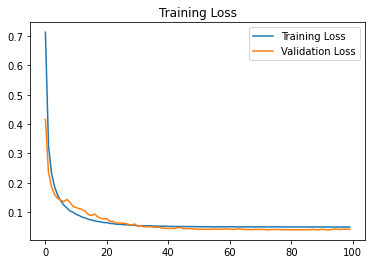

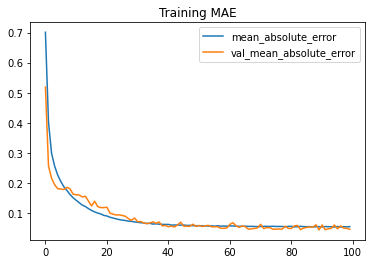

In [30]:
### AQUI FINAL
z = Dense(64, activation="relu")(combinedInput)
z = Dense(1, activation="linear")(z)
model = Model(inputs=[rn1.input, rn2.input], outputs=z)


history = compile_and_fit(model,[trainX, trainX1],trainY,[testX, testX1],testY,32,100,0.0001) #32,200,0.0001

plt.plot(history.history["loss"], label='Training Loss')
plt.plot(history.history["val_loss"], label='Validation Loss')
plt.title("Training Loss")
plt.legend()
plt.show()

plt.plot(history.history["mean_absolute_error"], label='mean_absolute_error')
plt.plot(history.history["val_mean_absolute_error"], label='val_mean_absolute_error')
plt.title("Training MAE")
plt.legend()
plt.show()

In [ ]:
### AQUI
#z = Dropout(0.7)(combinedInput)
z = Dense(64, activation="relu")(combinedInput)
#z = Dropout(0.7)(z)
#z = Conv1D(input_shape=(None, 64), kernel_size=2, filters=64)(z) 
#z = Dense(32, activation="relu")(z)
# z = Dropout(0.7)(z)

#z = Dense(32, activation="relu")(z)
#z = Dropout(0.7)(z)

# z = Dense(4, activation="relu")(z)
# #z = Dense(2, activation="relu")(z)
# z = Dropout(0.7)(z)

z = Dense(1, activation="linear")(z)
model = Model(inputs=[lstm_model.input, lstm_model1.input], outputs=z)


history = compile_and_fit(model,[trainX, trainX1],trainY,[testX, testX1],testY,32,100,0.0001) #32,200,0.0001

plt.plot(history.history["loss"], label='Training Loss')
plt.plot(history.history["val_loss"], label='Validation Loss')
plt.title("Training Loss")
plt.legend()
plt.show()

plt.plot(history.history["mean_absolute_error"], label='mean_absolute_error')
plt.plot(history.history["val_mean_absolute_error"], label='val_mean_absolute_error')
plt.title("Training MAE")
plt.legend()
plt.show()

In [ ]:
### AQUI
#z = Dropout(0.7)(combinedInput)
z = Dense(64, activation="relu")(combinedInput)
z = Dropout(0.7)(z)
z = Dense(64, activation="relu")(z)

z = Conv1D(input_shape=(None, 64), kernel_size=2, filters=16)(z) 
# z = Dense(8, activation="relu")(z)
# z = Dropout(0.7)(z)

# z = Dense(8, activation="relu")(z)
# z = Dropout(0.7)(z)

# z = Dense(4, activation="relu")(z)
# #z = Dense(2, activation="relu")(z)
# z = Dropout(0.7)(z)

z = Dense(1, activation="linear")(z)
model = Model(inputs=[lstm_model.input, lstm_model1.input], outputs=z)

history = compile_and_fit(model,[trainX, trainX1],trainY,[testX, testX1],testY,32,100,0.0001) #32,200,0.0001

plt.plot(history.history["loss"], label='Training Loss')
plt.plot(history.history["val_loss"], label='Validation Loss')
plt.title("Training Loss")
plt.legend()
plt.show()

plt.plot(history.history["mean_absolute_error"], label='mean_absolute_error')
plt.plot(history.history["val_mean_absolute_error"], label='val_mean_absolute_error')
plt.title("Training MAE")
plt.legend()
plt.show()

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True,)

In [ ]:
model.summary()

In [ ]:
# z = Dense(8, activation="relu")(combinedInput)
# z = Dropout(0.7)(z)

# z = Dense(8, activation="relu")(z)
# z = Dropout(0.7)(z)

# z = Dense(8, activation="relu")(z)
# z = Dropout(0.7)(z)

# z = Dense(4, activation="relu")(z)
# z = Dropout(0.7)(z)

# z = Dense(1, activation="linear")(z)
# model = Model(inputs=[lstm_model.input, lstm_model1.input], outputs=z)

# history = compile_and_fit(model,[trainX, trainX1],trainY,[testX, testX1],testY,64,200,0.0001)

# plt.plot(history.history["loss"], label='Training Loss')
# plt.plot(history.history["val_loss"], label='Validation Loss')
# plt.title("Training Loss")
# plt.legend()
# plt.show()

# plt.plot(history.history["mean_absolute_error"], label='mean_absolute_error')
# plt.plot(history.history["val_mean_absolute_error"], label='val_mean_absolute_error')
# plt.title("Training MAE")
# plt.legend()
# plt.show()

In [ ]:
# z = Dense(8, activation="relu")(combinedInput)
# z = Dropout(0.7)(z)
# #z = Dense(8, activation="relu")(z)
# z = Dense(4, activation="relu")(z)
# #z = Dense(2, activation="relu")(z)
# z = Dropout(0.7)(z)
# z = Dense(1, activation="linear")(z)
# model = Model(inputs=[lstm_model.input, lstm_model1.input], outputs=z)

# history = compile_and_fit(model,[trainX, trainX1],trainY,[testX, testX1],testY,32,200,0.0001)

# plt.plot(history.history["loss"], label='Training Loss')
# plt.plot(history.history["val_loss"], label='Validation Loss')
# plt.title("Training Loss")
# plt.legend()
# plt.show()

# plt.plot(history.history["mean_absolute_error"], label='mean_absolute_error')
# plt.plot(history.history["val_mean_absolute_error"], label='val_mean_absolute_error')
# plt.title("Training MAE")
# plt.legend()
# plt.show()

In [ ]:
plt.plot(history.history["loss"], label='Training Loss')
plt.plot(history.history["val_loss"], label='Validation Loss')
plt.title("Training Loss")
plt.legend()
plt.show()

plt.plot(history.history["mean_absolute_error"], label='mean_absolute_error')
plt.plot(history.history["val_mean_absolute_error"], label='val_mean_absolute_error')
plt.title("Training MAE")
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history["loss"], label='Training Loss')
plt.plot(history.history["val_loss"], label='Validation Loss')
plt.title("Training Loss")
plt.legend()
plt.show()

plt.plot(history.history["mean_absolute_error"], label='mean_absolute_error')
plt.plot(history.history["val_mean_absolute_error"], label='val_mean_absolute_error')
plt.title("Training MAE")
plt.legend()
plt.show()

In [ ]:
opt = Adam()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,mode='min')
model.compile(loss=tf.losses.MeanSquaredError(),optimizer=tf.optimizers.Adam(learning_rate=0.001),metrics=[tf.metrics.MeanAbsoluteError()])

#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,mode='min')
#  model.compile(loss=tf.losses.MeanSquaredError(),optimizer=tf.optimizers.Adam(learning_rate=LR),metrics=[tf.metrics.MeanAbsoluteError()])

model.fit(x=[trainX, trainX1], y=trainY,
          validation_data=([testX, testX1], testY),
          epochs=200,
          batch_size=4)

In [ ]:
plt.plot(history.history["loss"], label='Training Loss')
plt.plot(history.history["val_loss"], label='Validation Loss')
plt.title("Training Loss")
plt.legend()
plt.show()

plt.plot(history.history["mean_absolute_error"], label='accuracy')
plt.plot(history.history["val_mean_absolute_error"], label='val_accuracy')
plt.title("accuracy")
plt.legend()
plt.show()


In [ ]:
from datetime import datetime
from datetime import timedelta

In [ ]:
now = datetime.now()
now.month, now.year, now.day

In [ ]:
#df1 = client.query(f""" SELECT * FROM {PROJECT_ID}.raw.SNIM_PRECIOS_REFERENCIA WHERE date_time BETWEEN '2022-03-30' AND '2022-05-31' """).to_dataframe() 

In [ ]:
#WHERE Fecha BETWEEN '2022-03-30' AND '2022-04-31' 

In [ ]:
df1 = client.query(f""" SELECT DATE(fecha) as Fecha, ingenio as Ingenio, Estado, AVG(precio_base) AS Precio_Base_Promedio FROM (
SELECT A.*, B.Estado
FROM ( SELECT * FROM `zmx-sugar-sales-ml-d.raw.precio-base-historico` ) A
LEFT JOIN ( SELECT * FROM `zmx-sugar-sales-ml-d.raw.prueba_grupos` ) B
ON A.ingenio = B.Ingenio)
GROUP BY Fecha, Ingenio, Estado
""").to_dataframe() 

In [ ]:
# data_precio_bh_estado = client.query(f""" SELECT DATE(fecha) as Fecha, ingenio as Ingenio, Estado, AVG(precio_base) AS Precio_Base_Promedio FROM (
# SELECT A.*, B.Estado
# FROM ( SELECT * FROM `zmx-sugar-sales-ml-d.raw.precio-base-historico` ) A
# LEFT JOIN ( SELECT * FROM `zmx-sugar-sales-ml-d.raw.prueba_grupos` ) B
# ON A.ingenio = B.Ingenio)
# GROUP BY Fecha, Ingenio, Estado; """).to_dataframe() 

In [ ]:
trainX.shape

In [ ]:
#df1.Fecha.max()

In [ ]:
df2=df1.sort_values(by=['Fecha'])#, ascending=False)

In [ ]:
df3 = df2.tail(720)

In [ ]:
df4=funcion(df3,"Ingenio","Fecha")

In [ ]:
df4

In [ ]:
df4X=np.expand_dims(df4[1],axis=-1)
df4Y=np.expand_dims(df4[2],axis=-1)

In [ ]:
model.summary()

In [ ]:
#SIZE=30
#p = np.reshape(df2.tail(SIZE).values, (1,SIZE,720)) #(1463, 6, 1)
#p = np.reshape(df4.values, (1,6,1)) #30,24

In [ ]:
lstm_model1.predict(df4X)

In [ ]:
#model = Model(inputs=[lstm_model.predict(df4X), lstm_model1.predict(df4X)], outputs=z)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,mode='min')
  model.compile(loss=tf.losses.MeanSquaredError(),optimizer=tf.optimizers.Adam(learning_rate=LR),metrics=[tf.metrics.MeanAbsoluteError()])

In [ ]:
#aqui

In [ ]:
g=model.predict(df4X)

In [ ]:
g1=model.predict(df4X)

In [ ]:
g

In [ ]:
df4Y

In [ ]:
real = np.concatenate((df4X,df4Y), axis=1)
pred = np.concatenate((df4X,g), axis=1)

In [ ]:
df4X.shape ,  real.shape,  pred.shape , g.shape , df4Y.shape

In [ ]:
df4Y

In [ ]:
g

In [ ]:
train_split = np.concatenate((x_train,y_train), axis=1)

In [ ]:
#scaler = StandardScaler()
#scaler.fit(train_split)
inversed = a[3].inverse_transform(pred)

In [ ]:
 return train_df,val_df,test_df,train_mean,train_std

In [ ]:
train_mean = split(df)[3]
train_std = split(df)[4]

In [ ]:
g

In [ ]:
train_mean = split(df)[3]
train_std = split(df)[4]
g2 = g[0][0]*train_std[0]+train_mean[0]

In [ ]:
g2

In [ ]:
p

In [ ]:
df2.columns

In [ ]:
aux= pd.DataFrame(g2)
result = pd.DataFrame(aux.T.values,columns=df2.columns)

In [ ]:
result

### COMPARACION

In [ ]:
mask = (df1['Fecha'] == '2022, 7, 1')
df3 = df1.loc[mask]

In [ ]:
df3.shape

In [ ]:
y=prepro(df3)
del y["Fecha"]

In [ ]:
y

In [ ]:
y.columns

In [ ]:
result

In [ ]:
result.columns